<a href="https://colab.research.google.com/github/abhijith4126/Traffic-Congestion-Prediction/blob/main/URBAN_TRAFFIC_FLOW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Shape of Dataset: (200, 7)

First 5 Rows:
              Timestamp   Location  Vehicle_Count  Vehicle_Speed  \
0  2024-01-01 00:00:00  Sensor_02             63      55.680777   
1  2024-01-01 00:15:00  Sensor_04             50      76.680379   
2  2024-01-01 00:30:00  Sensor_02             42      48.598038   
3  2024-01-01 00:45:00  Sensor_02             55      59.796931   
4  2024-01-01 01:00:00  Sensor_01             46      48.094884   

   Congestion_Level Peak_Off_Peak  Target_Vehicle_Count  
0                 1      Off-Peak                    50  
1                 0      Off-Peak                    42  
2                 2      Off-Peak                    55  
3                 1      Off-Peak                    46  
4                 2      Off-Peak                    48  

Summary Statistics:
                   Timestamp   Location  Vehicle_Count  Vehicle_Speed  \
count                   200        200     200.000000     200.000000   
unique                  200          5  

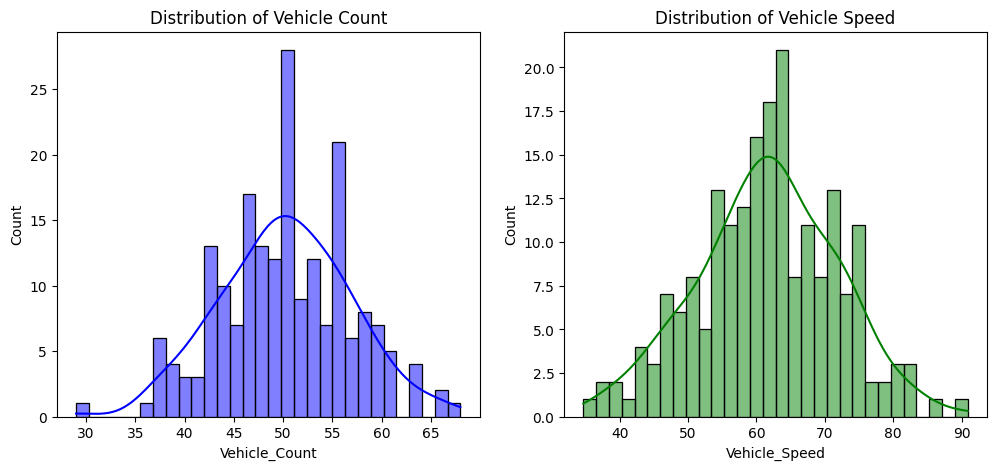

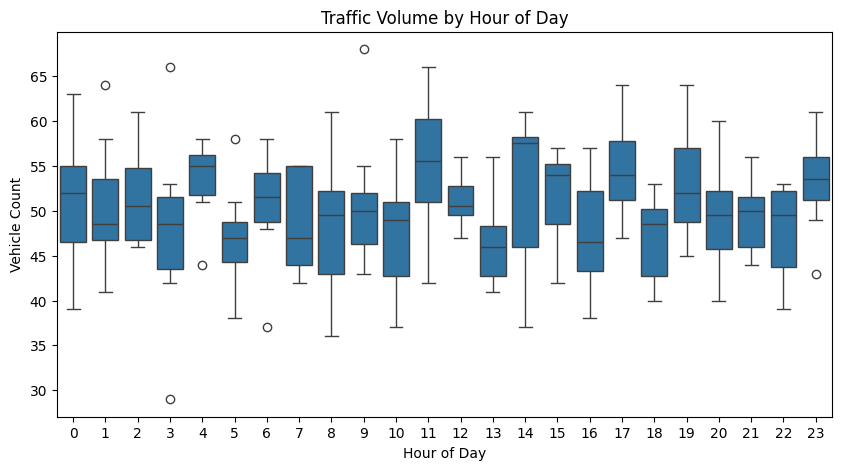

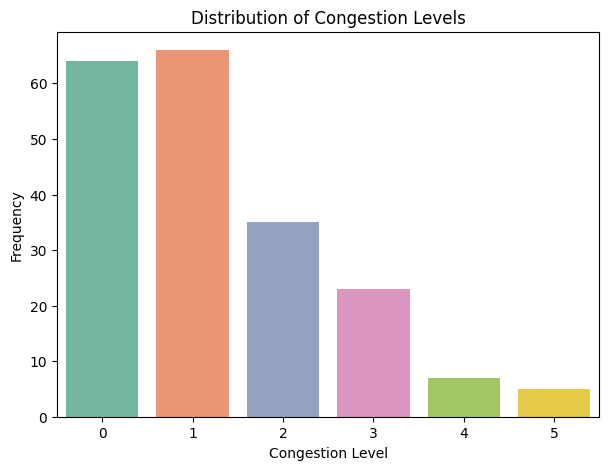

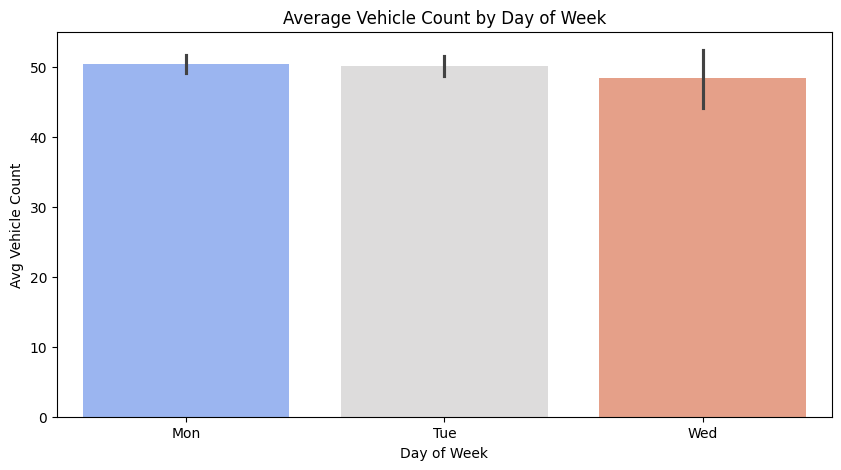

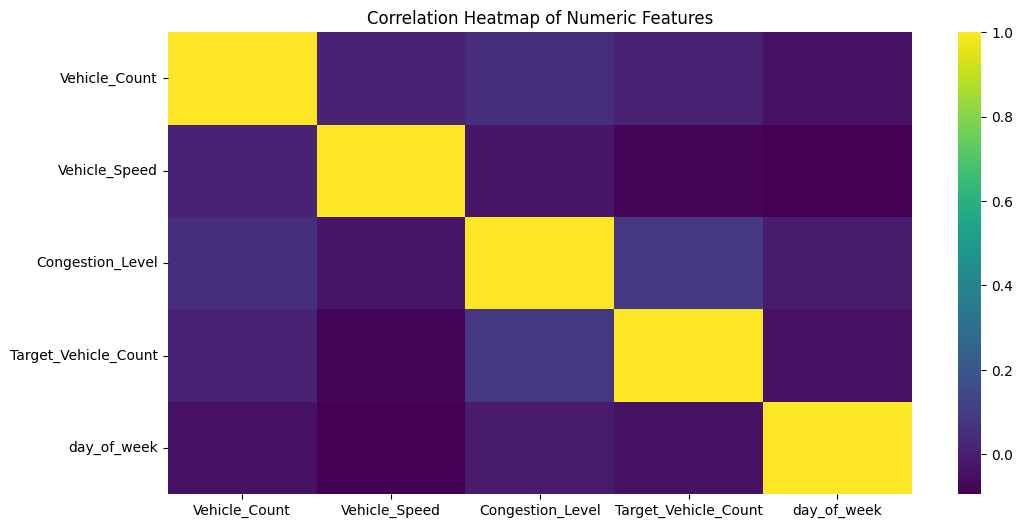

🔹 Regression Comparison
RF R²: -0.22093347884758607 MAE: 5.4495
XGB R²: -0.3755159378051758 MAE: 5.807328224182129
CatBoost R²: -0.29116724517175285 MAE: 5.789097376771134


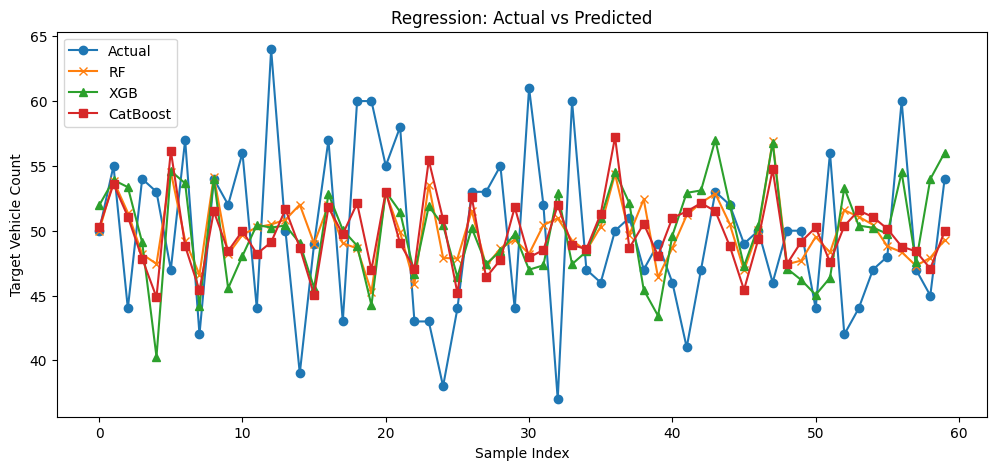


🔹 Classification Comparison (Accuracy)
RF Accuracy: 0.31666666666666665
XGB Accuracy: 0.3333333333333333
CatBoost Accuracy: 0.3333333333333333

--- Random Forest ---
              precision    recall  f1-score   support

           0       0.33      0.27      0.30        22
           1       0.30      0.56      0.39        16
           2       0.57      0.29      0.38        14
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2

    accuracy                           0.32        60
   macro avg       0.24      0.22      0.21        60
weighted avg       0.34      0.32      0.30        60


--- XGBoost ---
              precision    recall  f1-score   support

           0       0.53      0.36      0.43        22
           1       0.31      0.50      0.38        16
           2       0.40      0.29      0.33        14
           3       0.00      0.00      0.00         6
           4       0.00      0.00      0.00         2
  

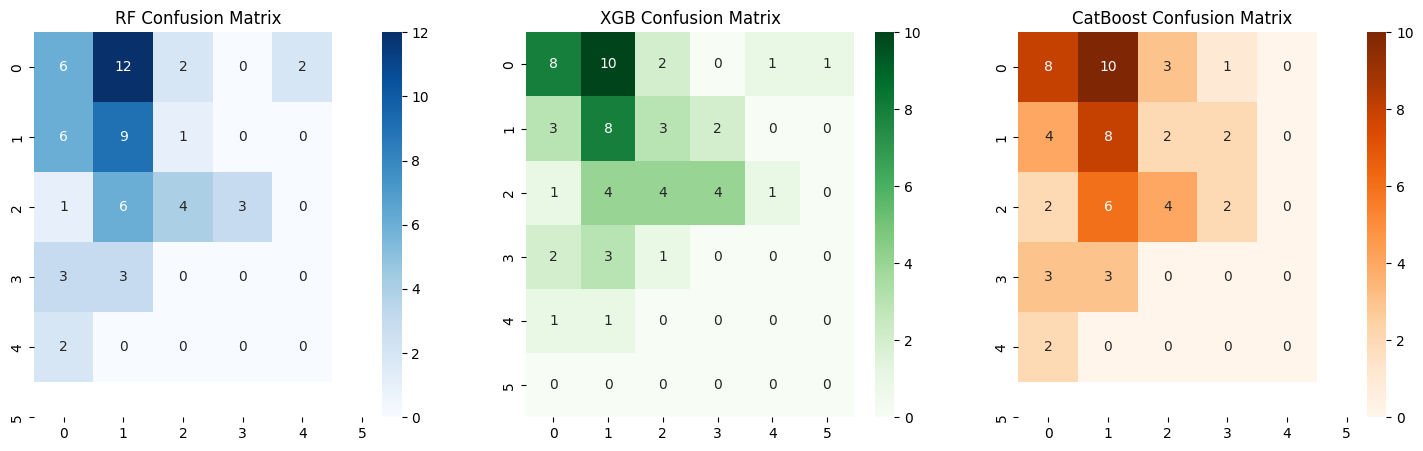

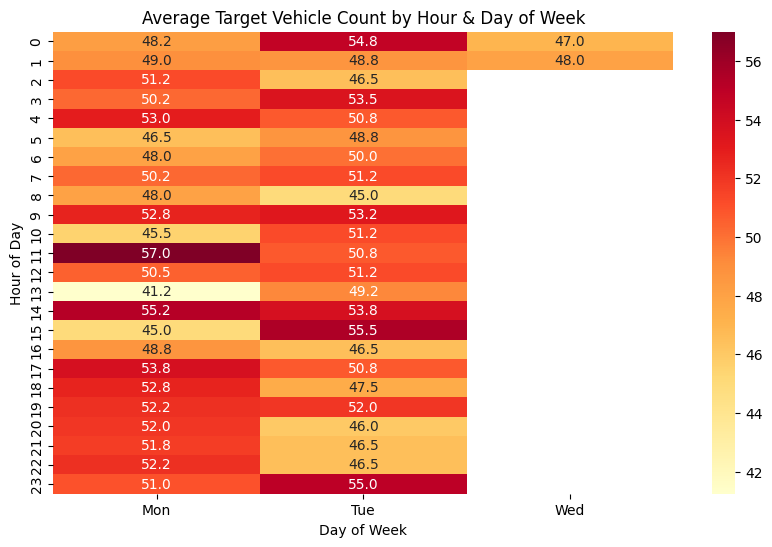

In [ ]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install xgboost
!pip install catboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier

data = pd.read_csv("/content/drive/MyDrive/Study materials/urban_traffic_flow_with_target.csv")

print("Shape of Dataset:", data.shape)
print("\nFirst 5 Rows:\n", data.head())
print("\nSummary Statistics:\n", data.describe(include='all'))
print("\nMissing Values:\n", data.isnull().sum())

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(data['Vehicle_Count'], bins=30, kde=True, color='blue')
plt.title("Distribution of Vehicle Count")

plt.subplot(1,2,2)
sns.histplot(data['Vehicle_Speed'], bins=30, kde=True, color='green')
plt.title("Distribution of Vehicle Speed")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='hour', y='Vehicle_Count',
            data=data.assign(hour=pd.to_datetime(data['Timestamp']).dt.hour))
plt.title("Traffic Volume by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Vehicle Count")
plt.show()

plt.figure(figsize=(7,5))
sns.countplot(x='Congestion_Level', data=data, hue='Congestion_Level', palette="Set2", legend=False)
plt.title("Distribution of Congestion Levels")
plt.xlabel("Congestion Level")
plt.ylabel("Frequency")
plt.show()

data['day_of_week'] = pd.to_datetime(data['Timestamp']).dt.dayofweek
day_map = {0:"Mon",1:"Tue",2:"Wed",3:"Thu",4:"Fri",5:"Sat",6:"Sun"}
data['day_name'] = data['day_of_week'].map(day_map)

plt.figure(figsize=(10,5))
sns.barplot(x='day_name', y='Vehicle_Count', data=data, estimator=np.mean,
            hue='day_name', palette="coolwarm", legend=False)
plt.title("Average Vehicle Count by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Avg Vehicle Count")
plt.show()

plt.figure(figsize=(12,6))
sns.heatmap(data.select_dtypes(include=[np.number]).corr(), annot=False, cmap="viridis")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour'] = data['Timestamp'].dt.hour
data['month'] = data['Timestamp'].dt.month
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

data['hour_sin'] = np.sin(2*np.pi*data['hour']/24)
data['hour_cos'] = np.cos(2*np.pi*data['hour']/24)
data['dow_sin'] = np.sin(2*np.pi*data['day_of_week']/7)
data['dow_cos'] = np.cos(2*np.pi*data['day_of_week']/7)

data['traffic_density'] = data['Vehicle_Count'] / (data['Vehicle_Speed'] + 1e-3)

cat_cols = ['Location','Peak_Off_Peak']
data = pd.get_dummies(data, columns=cat_cols, drop_first=True)

scaler = StandardScaler()
num_cols = ['Vehicle_Count','Vehicle_Speed','traffic_density']
data[num_cols] = scaler.fit_transform(data[num_cols])

target_reg = 'Target_Vehicle_Count'
target_clf = 'Congestion_Level'

X = data.drop([target_reg,target_clf,'Timestamp','day_name'], axis=1).select_dtypes(include=[np.number])
y_reg = data[target_reg]
y_clf = data[target_clf]

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.3, random_state=42)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.3, random_state=42)

rf_reg = RandomForestRegressor(random_state=42)
xgb_reg = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')
cb_reg = CatBoostRegressor(verbose=0, random_state=42)

rf_reg.fit(X_train_r, y_train_r)
xgb_reg.fit(X_train_r, y_train_r)
cb_reg.fit(X_train_r, y_train_r)

y_pred_rf_r = rf_reg.predict(X_test_r)
y_pred_xgb_r = xgb_reg.predict(X_test_r)
y_pred_cb_r = cb_reg.predict(X_test_r)

print("Regression Comparison")
print("RF R²:", r2_score(y_test_r, y_pred_rf_r), "MAE:", mean_absolute_error(y_test_r, y_pred_rf_r))
print("XGB R²:", r2_score(y_test_r, y_pred_xgb_r), "MAE:", mean_absolute_error(y_test_r, y_pred_xgb_r))
print("CatBoost R²:", r2_score(y_test_r, y_pred_cb_r), "MAE:", mean_absolute_error(y_test_r, y_pred_cb_r))

plt.figure(figsize=(12,5))
plt.plot(y_test_r.values[:100], label="Actual", marker='o')
plt.plot(y_pred_rf_r[:100], label="RF", marker='x')
plt.plot(y_pred_xgb_r[:100], label="XGB", marker='^')
plt.plot(y_pred_cb_r[:100], label="CatBoost", marker='s')
plt.title("Regression: Actual vs Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Target Vehicle Count")
plt.legend()
plt.show()

rf_clf = RandomForestClassifier(random_state=42, class_weight="balanced")
xgb_clf = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
cb_clf = CatBoostClassifier(verbose=0, random_state=42)

rf_clf.fit(X_train_c, y_train_c)
xgb_clf.fit(X_train_c, y_train_c)
cb_clf.fit(X_train_c, y_train_c)

y_pred_rf_c = rf_clf.predict(X_test_c)
y_pred_xgb_c = xgb_clf.predict(X_test_c)
y_pred_cb_c = cb_clf.predict(X_test_c)

print("\n Classification Comparison (Accuracy)")
print("RF Accuracy:", accuracy_score(y_test_c, y_pred_rf_c))
print("XGB Accuracy:", accuracy_score(y_test_c, y_pred_xgb_c))
print("CatBoost Accuracy:", accuracy_score(y_test_c, y_pred_cb_c))

print("\n--- Random Forest ---")
print(classification_report(y_test_c, y_pred_rf_c, zero_division=0))
print("\n--- XGBoost ---")
print(classification_report(y_test_c, y_pred_xgb_c, zero_division=0))
print("\n--- CatBoost ---")
print(classification_report(y_test_c, y_pred_cb_c, zero_division=0))

def get_metrics(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        "Model": model_name,
        "Precision (Macro)": report["macro avg"]["precision"],
        "Recall (Macro)": report["macro avg"]["recall"],
        "F1-score (Macro)": report["macro avg"]["f1-score"],
        "Precision (Weighted)": report["weighted avg"]["precision"],
        "Recall (Weighted)": report["weighted avg"]["recall"],
        "F1-score (Weighted)": report["weighted avg"]["f1-score"]
    }

results = []
results.append(get_metrics(y_test_c, y_pred_rf_c, "Random Forest"))
results.append(get_metrics(y_test_c, y_pred_xgb_c, "XGBoost"))
results.append(get_metrics(y_test_c, y_pred_cb_c, "CatBoost"))

results_df = pd.DataFrame(results)
print("\n Model Comparison (Macro & Weighted Avg Scores)")
print(results_df)

cm_rf = confusion_matrix(y_test_c, y_pred_rf_c)
cm_xgb = confusion_matrix(y_test_c, y_pred_xgb_c)
cm_cb = confusion_matrix(y_test_c, y_pred_cb_c)

plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=rf_clf.classes_, yticklabels=rf_clf.classes_)
plt.title("RF Confusion Matrix")

plt.subplot(1,3,2)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Greens',
            xticklabels=xgb_clf.classes_, yticklabels=xgb_clf.classes_)
plt.title("XGB Confusion Matrix")

plt.subplot(1,3,3)
sns.heatmap(cm_cb, annot=True, fmt='d', cmap='Oranges',
            xticklabels=cb_clf.classes_, yticklabels=cb_clf.classes_)
plt.title("CatBoost Confusion Matrix")
plt.show()

heatmap_data = data.pivot_table(index='hour', columns='day_name', values='Target_Vehicle_Count', aggfunc='mean')

plt.figure(figsize=(10,6))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="YlOrRd")
plt.title("Average Target Vehicle Count by Hour & Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Hour of Day")
plt.show()
